# Detecting Faulty Products in the Diaper Manufacturing Process

## Introduction

The capstone project for Data Science 420 focuses on diaper manufacturing quality. In our previous step, we discovered how the manufacturing process works and that the product quality in this process is monitored using heat sensors, glue sensors, and glue level. To detect faulty products in the manufacturing process, we will use a manufacturing data set from the UCI Machine Learning Repository with 590 individual unlabeled sensors. 

**Our goal in this project is to predict whether a product in the diaper manufacturing process is faulty.** The target is from a labels file, which we will need to join to our feature set. The data modeling performed within this notebook has been divided into the three main phases shown below.

**Phase 1**

- Join features to labels
- Impute missing data
- Remove unncessary columns
- Split data into a train, validation, and test set
- Solve for class imbalance
- Apply feature selection methods
- Define performance metrics

**Phase 2**

- Build & assess benchmark models
    - Decision Tree
    - Random Forest
    - Support Vector Machine

**Phase 3**

- Build & assess final models
    - Fully connected neural network using sklearn
    - Fully connected neural network using TensorFlow with dropout

## Phase 1

### Load Data

The first set of data to load is our manufacturing sensor data. Each feature in this data set is a different sensor, providing us information about a given product.

In [1]:
#load data
#check data shape

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = np.loadtxt('data/secom.data')

print(data.shape)

(1567, 590)


In [2]:
secom = pd.DataFrame(data)
secom.head()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


Note that we have 590 different sensors/features and only 1567 observations.

### Labels

The labels data set will help us build our supervised learning models. The target indicates whether a particular observation is faulty. We can use this information to train our models and then predict on a subset of the joined data set. Let's clean this data and then join it to our sensor data.

In [3]:
#read in labels data

with open('data/secom_labels.data', 'r') as f:
    labels = f.readlines()
    
print(labels[:3])

['-1 "19/07/2008 11:55:00"\n', '-1 "19/07/2008 12:32:00"\n', '1 "19/07/2008 13:17:00"\n']


To clean our labels, we can start by splitting each value in the list using spaces. Then we can replace any double quote with a single quote and strip any other unnecessary spaces. 

In [4]:
#split by spaces

labels = [label.split(' ') for label in labels]

In [5]:
#replace double quotes and strip extra spaces

labels = [[entry.strip().replace('"', '') for entry in label] for label in labels]

In [6]:
#convert to dataframe

labels = pd.DataFrame(labels, columns = ['target', 'date', 'time'])
labels = labels['target']

We now have the labels for each obervation. Let's join this to the feature set.

In [7]:
#join labels to secom dataset

df = secom.join(labels)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,target
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


### Data Cleaning & Train-Test Split

With our data set in one piece, we can now focus on the missing values in the data set. Since we are looking to find features most predictive of defective products, we will likely not find signal in columns with an excessive number of missing values given the size of our data set. Let's go ahead and drop columns that have > 30% of the 1567 observations as null values because we are unlikely to find any of these features to be useful in our model.

In [8]:
#dropping columns with over 30% null values
drop_na = list(df.loc[:,df.isna().sum() > (df.count())*(3/10)].columns)
df.drop(drop_na, axis=1, inplace=True)

The target also had the negative cases (no defect) as -1. It is good practice to replace these values with 0.

In [9]:
#replace -1 in target with 0
df['target'] = df['target'].replace('-1', 0)

Before we do any further analysis, we must split our data set into a train, validation, and test set. To understand whether the models we build are high performing, they must be able to generalize well on unseen data. In supervised learning, an under fit model occurs when it is unable to capture the underlying pattern of a data set. An over fit model occurs when a model captures the noise of the data, along with the underlying pattern. As we build our models, we are looking to choose a model that captures regularities in the training data, but can also generalize on unseen data.

By setting aside 20% of our data to the validation and test set (10% each), we can use our models that we trained on the other 80% to predict on unseen data. This is a way for us to simulate the future performance of the model in production. The validation set can help us tune the parameters of each model, while the test set will be saved until the very end of our data modeling process.

In [10]:
#drop target from X

X = df.drop(['target'], axis = 1)
y = df['target'].astype('int64')

In [11]:
#split into 80-20 train-val/test
#50-50 val/test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.50, random_state = 1)

In [12]:
X_train = X_train.reset_index(drop = True)
X_valid = X_valid.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

In [13]:
print('X train shape: {}'.format(X_train.shape))
print('X validation shape: {}'.format(X_valid.shape))
print('X test shape: {}'.format(X_test.shape))

X train shape: (1253, 558)
X validation shape: (157, 558)
X test shape: (157, 558)


Splitting our data into three sets left us with the above. Notice how we have 558 features in each of our data sets. Many of these features are not likely to be predictive and keeping them leads to unnecessary complexity and will cause longer runtimes for the models we will be building. In our next steps, we will impute missing values, standardize each data set, deal with class imbalance, and then look to narrow down our feature set.

In [14]:
#fill missing values with the mean of the train set

for column in X_train.columns:
    X_train[column].fillna(X_train[column].mean(), inplace=True)
    X_valid[column].fillna(X_train[column].mean(), inplace=True)
    X_test[column].fillna(X_train[column].mean(), inplace=True)

Notice how we used the mean of the train set to impute all three data sets. Part of the model building process is not allowing any information from the train set to leak into the validation/test set. Allowing data leakage will not deliver an accurate simulation of how the model might perform in production. We will therefore, use the same logic to standardize each data set below.

In [15]:
#initialize standardscaler
#fit numeric columns on train set
#apply to each data set
from sklearn.preprocessing import StandardScaler

znormalizer = StandardScaler()
znormalizer.fit(X_train)
X_train = pd.DataFrame(znormalizer.transform(X_train), columns = X_train.columns)
X_valid = pd.DataFrame(znormalizer.transform(X_valid), columns = X_valid.columns)
X_test = pd.DataFrame(znormalizer.transform(X_test), columns = X_test.columns)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,576,577,582,583,584,585,586,587,588,589
0,-0.958601,0.927555,-0.213206,2.119234,-0.040224,0.0,-2.270271,0.145725,-0.562111,0.600802,...,4.793848,6.258281,-0.699295,0.051608,-0.089278,0.051607,2.667230,0.127941,-0.080762,-0.716431
1,-1.059148,0.038292,-2.912957,0.330101,-0.057009,0.0,-0.367259,0.535636,-0.241648,-0.671046,...,-0.226081,0.318446,0.399258,-0.384719,-0.355759,-0.371223,0.025725,-0.256531,-0.283599,-0.372816
2,-1.433404,0.754126,0.100630,2.788137,-0.053570,0.0,-2.381693,0.183458,-0.251034,-0.573212,...,-0.254379,0.291199,-0.439112,-0.006218,0.056075,-0.005771,-0.897211,0.204835,0.257299,0.801493
3,0.462736,-0.761869,0.418952,-0.654294,-0.066859,0.0,0.488114,-0.105831,1.316421,0.013795,...,-0.233396,-0.689358,-1.046207,-0.248038,-0.186181,-0.233365,-0.411874,1.665826,1.643351,0.956293
4,-0.299742,1.183426,0.760062,0.772441,-0.046513,0.0,-0.689508,0.271502,1.197086,-1.740703,...,-0.211346,-0.467898,1.121990,-0.016732,-0.040827,-0.021685,-0.395961,-0.377364,-0.486436,-0.228242


### Dealing with Class Imbalance

Before we begin feature selection and modeling, it is essential to check the distribution of our target. An imbalanced target can lead to biases in our predictions towards the majority class. In our case, we are dealing with defects in the manufacturing process. Given the context, it is likely that positive cases are very low in proportion to negative cases. Because we are more interested in the model identifying the minority class (when there is a defect in the manufacturing process), we must pay special attention to the class imbalance problem in this data set. Our models will likely have challenges predicting the minority class because of the lack of historical examples each model will be able to train on.

Before we apply any methods to solve for this problem, let's take a look at the distribution of the target feature.

In [16]:
y_train.value_counts()

0    1169
1      84
Name: target, dtype: int64

This is clearly a very imbalanced data set with only 7% of the cases as positive (class 1). To balance the classes, we can use SMOTE to over sample the minority class (in this case, the defects). SMOTE will balance the number of observations in each class by manufacturing synthetic data using a kmeans clustering algorithm.

SMOTE is a widely used approach to synthesizing new examples in a data set. The algorithm selects a minority class at random, finds its k nearest minority class neighbor, and then creates a synthetic instance by choosing one of the k nearest neighbors at random to form a line segment in the feature space. SMOTE is useful to us because we should see a balanced set of positive and negative classes in our training data after it is applied.

In the next step, we will apply SMOTE to *both the training and validation set*. Due to imbalance in each of our data sets and the small overall sample size we are dealing with, we should expect model selection to be a challenge. When the minority class has few samples, results can be both difficult to trust and replicate. By balancing both train and validation sets, there is a high likelihood of a large variance in performance between train-validation to test set (because we will not be balancing our test set target variable). However, making this intentional adjustment can help us select more a consistent and robust model for production.

In [17]:
#set number of k nearest neighbors
#fit on training data

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0, k_neighbors = 8)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_valid, y_valid = smote.fit_resample(X_valid, y_valid)

In [18]:
#check class distributions

print(y_train.value_counts())
print(y_valid.value_counts())

1    1169
0    1169
Name: target, dtype: int64
1    147
0    147
Name: target, dtype: int64


The classes are now balanced in both data sets, meaning SMOTE did its job. We can now move into feature selection. 

### Feature Selection

We're going to start by doing a simple mutual information classification to give us a subset of important features to use in our predictive model. Mutual information highlights important statistical dependencies within in our data set in the context of our target variable.

The definition for mutual information is provided below:

*A quantity called mutual information measures the amount of information one can obtain from one random variable given another*

Running a mutual information classification is an efficient way of selecting a set of features that can explain the target variable from a larger data set. We can then use the subset of features chosen by the mutual information classification and run a stepwise feature selection algorithm to iteratively select a smaller set of predictive features for our model. By using mutual information classification in our first step, our recursive feature elimination step that we perform later will be able to run more efficiently because we will have already narrowed down our features from the original data set.

In [19]:
#run mutual info classification
#convert output to list and show 125 highest mutual information features

from sklearn.feature_selection import mutual_info_classif
import heapq

mi_score = mutual_info_classif(np.array(X_train), y_train, random_state = 7)

mi = mi_score.tolist()
num = 125

m = heapq.nlargest(num, enumerate(mi), key = lambda mi: mi[1])

We now have the 125 features with the highest mutual information, as shown in the list above. We can use these features to subset our original data set before using a step wise feature selection method called recursive feature elimination (RFE).

Before moving onto RFE, let's subset our features on the ones we selected using mutual information classification.

In [21]:
X_col = [i[0] for i in m]
X_train = X_train.iloc[:, X_col]
X_train.head()

,376,166,131,143,366,584,219,377,121,239,...,171,551,58,19,311,560,587,227,561,447
0,0.002389,-0.166872,0.704207,-0.823328,-0.342906,-0.089278,0.326860,0.055307,0.344013,-0.069668,...,-0.780339,-7.015448e-01,0.497086,-0.389515,0.134134,-0.094124,0.127941,-0.272353,-0.027531,-0.118287
1,1.123169,-0.608406,-1.153850,0.279585,-0.699495,-0.355759,-0.331345,0.504585,-0.674042,0.075227,...,-0.291039,-2.758800e-16,-1.085006,-0.351687,1.272236,0.048701,-0.256531,-0.631415,0.544045,0.990386
2,0.375982,1.246035,0.571488,-2.083800,-0.654921,0.056075,0.147350,-1.067890,-2.506541,-0.576801,...,-0.581357,-4.406296e-01,-0.684255,0.345927,1.090698,-0.522597,0.204835,0.187984,-0.408390,1.290749
3,0.749576,-0.608406,0.969643,-0.193092,-0.521200,-0.186181,0.685881,-0.843250,-0.266820,-0.721696,...,-0.224169,-2.758800e-16,-0.433351,-0.061821,1.520105,3.461252,1.665826,0.132743,1.158870,1.381205
4,0.375982,0.098048,-0.578737,-0.980887,-0.744068,-0.040827,1.463760,0.504585,-0.572237,-0.214563,...,-0.085534,1.930214e-01,1.494896,0.325254,0.560050,-0.050324,-0.377364,-0.272353,0.434010,0.855861


In [22]:
#repeat for validation and test set

X_valid = X_valid.iloc[:, X_col]
X_test = X_test.iloc[:, X_col]

We are going to use a recursive feature elimination (RFE) random forest classifier to choose the best features from our subsetted data. RFE is a wrapper style feature selection method that ranks all of the features in our data by importance. Then, the least important features are pruned from the current set of features. This procedure is recursively repeated until we reach a desired number of features. We will perform this model by allowing it to specify the non essential features. Then, we can simply subset the data on only the important features specified by RFE. Because this process can be computationally expensive, we will set our cross validation parameter to 3. 

After running RFE, we can output a chart that will inform us of our classification accuracy by # of features. This can tell us where accuracy tends to plateau.

**Note: Long run time**

In [23]:
#initialize random forest classifier
#set cvs and performance metric
#fit

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

rfc = RandomForestClassifier()
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(3), scoring='f1_weighted')
rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(), scoring='f1_weighted')

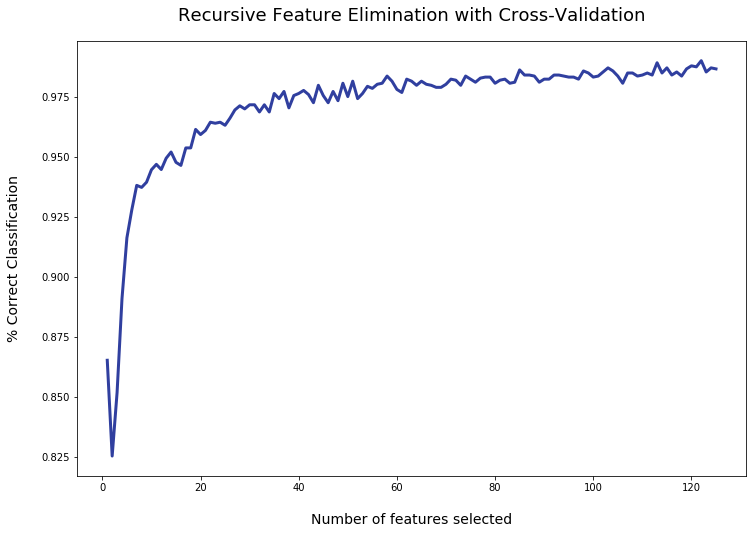

In [24]:
plt.figure(figsize=(12, 8))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

Note that we used the F1 weighted score to classify our observations. Given that we are looking to predict defective products and see extreme class imbalance in our data set, we need to prioritize performance metrics that will tell us how well we are predicting positive cases. The F1 weighted score can be interpreted as the weighted average of the model's precision and recall.

In addition to the F1 score, we will be using a few other performance metrics to evaluate our models' performance going forward. We will be reviewing the AUC (area under the curve), precision, recall, accuracy, and F1 score for each model. We can also see the actual number observations classified into each bucket (TP, FP, TN, FN) using a confusion matrix.

In our next step, we can output the features RFE did not find to be predictive.

In [25]:
#output unimportant features

print(np.where(rfecv.support_ == False)[0])

[ 64  82 106]


The array above shows 3 sensors that RFE did not find to be predictive. We can now subset our data sets on the remaining features.

In [26]:
#store important features in RFE_col

back_features = pd.DataFrame(rfecv.support_)
sel_back = back_features[0].loc[back_features[0] == True]
RFE_col = sel_back.index.tolist()

In [27]:
#subset train, valid, test sets

X_train = X_train.iloc[:, RFE_col]
X_valid = X_valid.iloc[:, RFE_col]
X_test = X_test.iloc[:, RFE_col]

We can now output the results and see which features RFE chose for us.

In [28]:
#display new data frame
X_train.head()

,376,166,131,143,366,584,219,377,121,239,...,171,551,58,19,311,560,587,227,561,447
0,0.002389,-0.166872,0.704207,-0.823328,-0.342906,-0.089278,0.326860,0.055307,0.344013,-0.069668,...,-0.780339,-7.015448e-01,0.497086,-0.389515,0.134134,-0.094124,0.127941,-0.272353,-0.027531,-0.118287
1,1.123169,-0.608406,-1.153850,0.279585,-0.699495,-0.355759,-0.331345,0.504585,-0.674042,0.075227,...,-0.291039,-2.758800e-16,-1.085006,-0.351687,1.272236,0.048701,-0.256531,-0.631415,0.544045,0.990386
2,0.375982,1.246035,0.571488,-2.083800,-0.654921,0.056075,0.147350,-1.067890,-2.506541,-0.576801,...,-0.581357,-4.406296e-01,-0.684255,0.345927,1.090698,-0.522597,0.204835,0.187984,-0.408390,1.290749
3,0.749576,-0.608406,0.969643,-0.193092,-0.521200,-0.186181,0.685881,-0.843250,-0.266820,-0.721696,...,-0.224169,-2.758800e-16,-0.433351,-0.061821,1.520105,3.461252,1.665826,0.132743,1.158870,1.381205
4,0.375982,0.098048,-0.578737,-0.980887,-0.744068,-0.040827,1.463760,0.504585,-0.572237,-0.214563,...,-0.085534,1.930214e-01,1.494896,0.325254,0.560050,-0.050324,-0.377364,-0.272353,0.434010,0.855861


### Initial Models

Now that we have balanced train and validation sets that also have a more manageable set of features, we are ready to begin modeling. We will begin by building a decision tree classifier before moving to random forest and SVM classifiers. The decision tree classifier will give us more intuition about the decision making within the model, where the most important splits are, and more information about the non linear relationships within our data set.

#### Decision Tree

We trained our decision tree classifier using a greedy approach to parameter tuning. The three parameters we tuned in the model are defined here:
- min_samples_leaf - Specifies the minimum # of samples required to be at a leaf node
- max_leaf_nodes - The maximum number of leaf nodes in the tree. More leaves generally lead to more overfitting
- min_samples_split - Specifies the minimum # of samples required to split an internal node

We incremented the max leaf node parameter by 1 (starting with 3) until performance dropped off before using the same approach on the minimum sample leaf and split parameters. This left us with parameters in the code below.

In [29]:
#train decision tree
#predict on train and val
#print accuracy on both

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dtree = DecisionTreeClassifier(min_samples_leaf = 2, max_leaf_nodes = 6, min_samples_split = 2).fit(X_train, y_train)

y_dtree_train = dtree.predict(X_train) 
y_dtree_valid = dtree.predict(X_valid) 

print("Decision Tree accuracy on training set: {:.1f}%".format(accuracy_score(y_train, y_dtree_train)*100))
print("Decision Tree accuracy on validation set: {:.1f}%".format(accuracy_score(y_valid, y_dtree_valid)*100))

Decision Tree accuracy on training set: 76.0%
Decision Tree accuracy on validation set: 74.8%


Our accuracy is fairly close between train and validation sets, which is a good sign. To understand what is happening under the hood, we must visualize our decision tree and then look at the performance metrics we mentioned above to get a better sense of how well the model is classifying positive cases.

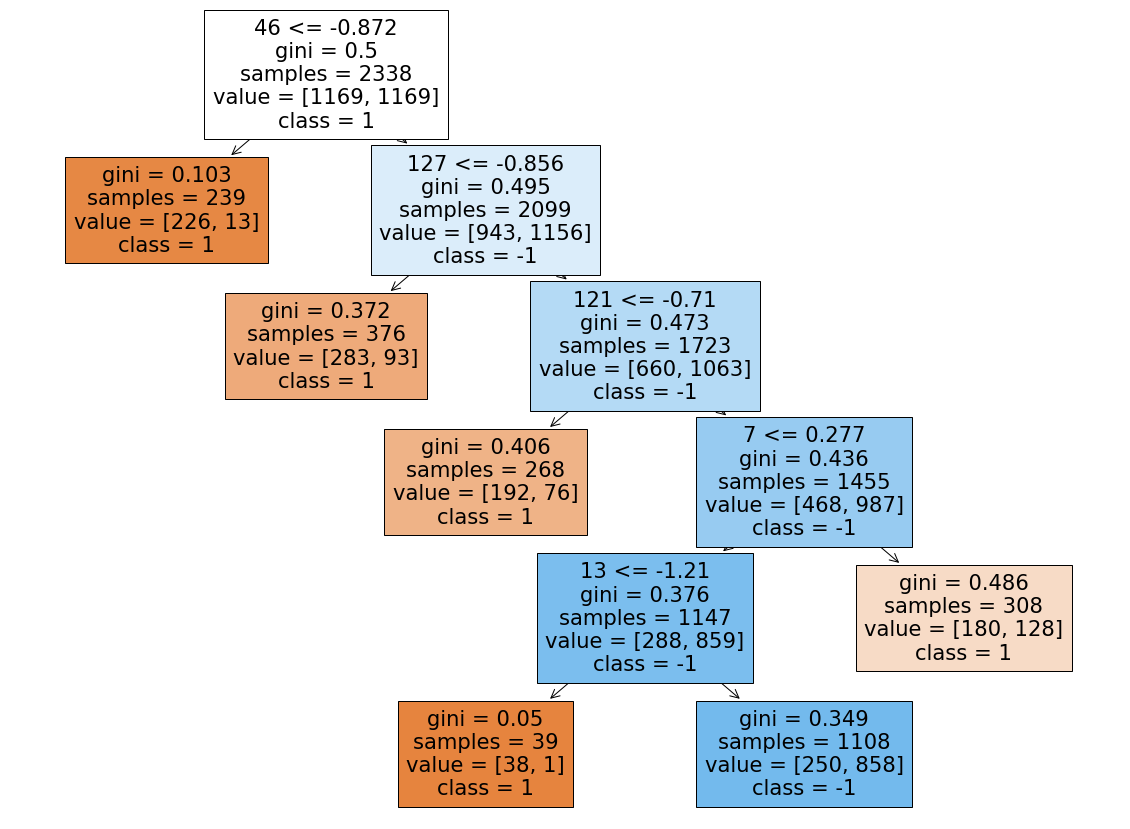

In [30]:
#plot decision tree

from sklearn import tree
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15)) 
tree.plot_tree(dtree,
               feature_names=X.columns,  
               class_names=['1', '-1'],
               filled=True);

To understand the decision tree, we begin with the root node. This classifier uses the gini coefficient to determine each split. Notice how at the root node, we can see the highest gini coefficient of any node in the tree. This means that the feature identified in the root node is the most important according to our model. From this node, the model divides the classes evenly. The left split becomes a leaf/terminal node, where no further splits are made indicating that the model has made a final decision on these particular observations. The right split sends the rest of the observations down a deep path to figuring out which class they stand in.

With this understanding, we can now move onto getting a precision and recall score from our model. The purpose of both metrics is to better understand how our model is classifying the positive class.

In [31]:
#print precision/recall for train-val

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_train = precision_score(y_train, y_dtree_train, pos_label = 1) * 100
precision_valid = precision_score(y_valid, y_dtree_valid, pos_label = 1) * 100
recall_train = recall_score(y_train, y_dtree_train, pos_label = 1) * 100
recall_valid = recall_score(y_valid, y_dtree_valid, pos_label = 1) * 100

print("Precision on training data: {:.1f}%.".format(precision_train))
print("Recall on training data: {:.1f}%.\n".format(recall_train))
print("Precision on validation data: {:.1f}%.".format(precision_valid))
print("Recall on validation data: {:.1f}%.".format(recall_valid))

Precision on training data: 77.4%.
Recall on training data: 73.4%.

Precision on validation data: 75.2%.
Recall on validation data: 74.1%.


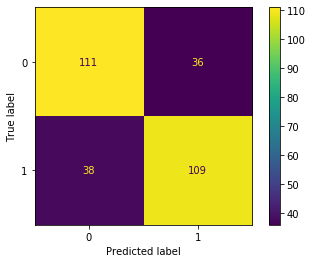

In [32]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(dtree, X_valid, y_valid);

Let's now check the AUC of the model on both data sets. AUC (area under the ROC curve) measures the two dimensional area under the ROC curve. This curve has the axes, False Positivity Rate (FPR) and True Positivity Rate (TPR). One way of thinking about AUC is as the probability that the model ranks a random positive example more highly than a negative example. 100% is the highest possible AUC score and indicates that every classification made by the model was correct.

In [33]:
from sklearn.metrics import roc_auc_score

print("Training AUC: {:.1f}%.".format(roc_auc_score(y_train, y_dtree_train)*100))
print("Validation AUC: {:.1f}%.".format(roc_auc_score(y_valid, y_dtree_valid)*100))

Training AUC: 76.0%.
Validation AUC: 74.8%.


The results above tell us that the model is classifying positive cases quite well on both the train and validation sets. Notice that the precision and recall scores are very close to one another, which is a good sign because it tells us that we are balancing the number of false negatives and positives almost evenly. This is also confirmed by the confusion matrix, which shows 36 false positives and 38 false negatives out of 294 total observations.

Next, we can implement a random forest classifier, which can be thought of as a more robust version of a decision tree. The random forest model uses many weak decision trees to classify the target instead of relying on only one like the decision tree. This model does however, require more tuning. We will tune the model using a grid search, which can find us the optimal parameters we should use in our model. Note that the parameters are very similar to the decision tree we tuned above. The main difference is that we need to specify the number of estimators/learners to use in the model.

#### Random Forest

In [34]:
#set parameter grid
#initialize rf regressor
#perform grid search - 2 cvs
#print best parameters

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [10, None],
    'max_features': [8, 10],
    'n_estimators': [800, 1000]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
grid_search.best_params_

We can now use the parameters specified by the grid search to train our random forest classifier.

In [35]:
#use optimal parameters from grid search
#run rf classifier

from sklearn.ensemble import RandomForestClassifier

hypers = {"n_estimators": 1000, "max_features": 8, "max_depth": 10, 
          "min_samples_leaf": 2, "min_samples_split": 2}
clf_rf = RandomForestClassifier(class_weight = 'balanced',
                                verbose = True, **hypers).fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   17.8s finished


In [36]:
#predict on train-val
#print accuracy

y_hat_train_rf = clf_rf.predict(X_train)
y_hat_valid_rf = clf_rf.predict(X_valid)

acc_train_rf = accuracy_score(y_train, y_hat_train_rf)
acc_val_rf = accuracy_score(y_valid, y_hat_valid_rf)

print('Train set random forest accuracy: {:.2f}%'.format(acc_train_rf * 100))
print('Validation set random forest accuracy: {:.2f}%'.format(acc_val_rf * 100))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train set random forest accuracy: 99.70%
Validation set random forest accuracy: 90.48%


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


We got much better accuracy on both the training and validation sets, as expected. Let's check our precision, recall, and output the AUC of this model.

In [37]:
#print precision/recall

precision_train_rf = precision_score(y_train, y_hat_train_rf, pos_label = 1) * 100
precision_valid_rf = precision_score(y_valid, y_hat_valid_rf, pos_label = 1) * 100
recall_train_rf = recall_score(y_train, y_hat_train_rf, pos_label = 1) * 100
recall_valid_rf = recall_score(y_valid, y_hat_valid_rf, pos_label = 1) * 100

print("Precision on training data: {:.1f}%".format(precision_train_rf))
print("Recall on training data: {:.1f}% \n".format(recall_train_rf))
print("Precision on validation data: {:.1f}%".format(precision_valid_rf))
print("Recall on validation data: {:.1f}%".format(recall_valid_rf))

Precision on training data: 99.4%
Recall on training data: 100.0% 

Precision on validation data: 96.9%
Recall on validation data: 83.7%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


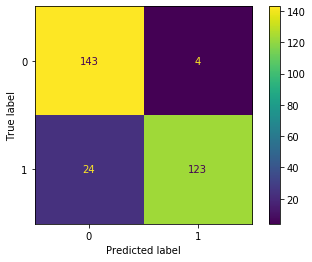

In [38]:
plot_confusion_matrix(clf_rf, X_valid, y_valid);

In [39]:
print("Training AUC: {:.1f}%.".format(roc_auc_score(y_train, y_hat_train_rf)*100))
print("Validation AUC: {:.1f}%.".format(roc_auc_score(y_valid, y_hat_valid_rf)*100))

Training AUC: 99.7%.
Validation AUC: 90.5%.


While we are seeing significant improvement in each of our performance metrics, we are beginning to see a larger drop off from train to validation sets. This model has very good precision, but notice how the recall score lags far behind the training set. This indicates that there is some overfitting happening.

We can see what features the model is highlighting by looking at a feature importance table. We can use this to compare it with our original decision tree to see how it might differ.

In [40]:
#display top 5 features from rf

var_imp = pd.DataFrame({"feature": X_train.columns, "importance": clf_rf.feature_importances_})
var_imp.sort_values(by = 'importance', ascending = False).head(5)

,feature,importance
73,33,0.027652
8,121,0.026457
7,377,0.026402
46,130,0.025406
120,561,0.024900


Interestingly, both models are identifying mostly different features as important. Given the difference in prediction accuracy between the two, this is not too surprising.

#### Support Vector Machine

Next, we can try an SVM before finalizing a model. SVMs are known to perform quite well on sparse data like what we have. To classify observations into two groups, SVMs use a separating line (called a hyperplane), where the distance to that line and the nearest point is called the margin. SVM looks the maximize the margin between the point and the separating line. If the data cannot be cleanly separated, the SVM can expand the number of dimensions (otherwise known as the kernel trick) or increase the cost of misclassified examples (C parameter in sklearn).

We have tuned our SVM model once again, using a greedy approach. Defined below are the parameters we iterated through before hitting a plateau on our performance metrics.
- C - Regularization parameter
- gamma - Kernel coefficient
- kernel - Specifies the type of kernel to map points into higher dimensional space

In [41]:
#initialize svm
#predict on train, validation
#print accuracy

from sklearn.svm import SVC

svmc = SVC(C = 1.0, gamma = 'scale', kernel = 'rbf')
svmc.fit(X_train, y_train)

y_hat_train_svm = svmc.predict(X_train)
y_hat_valid_svm = svmc.predict(X_valid)

acc_train_svm = accuracy_score(y_train, y_hat_train_svm)
acc_val_svm = accuracy_score(y_valid, y_hat_valid_svm)

print('Train set svm accuracy: {:.2f}%'.format(acc_train_svm * 100))
print('Validation set svm accuracy: {:.2f}%'.format(acc_val_svm * 100))

Train set svm accuracy: 99.79%
Validation set svm accuracy: 86.39%


In [42]:
precision_train_svm = precision_score(y_train, y_hat_train_svm, pos_label = 1) * 100
precision_valid_svm = precision_score(y_valid, y_hat_valid_svm, pos_label = 1) * 100
recall_train_svm = recall_score(y_train, y_hat_train_svm, pos_label = 1) * 100
recall_valid_svm = recall_score(y_valid, y_hat_valid_svm, pos_label = 1) * 100

print("Precision on training data: {:.1f}%".format(precision_train_svm))
print("Recall on training data: {:.1f}% \n".format(recall_train_svm))
print("Precision on validation data: {:.1f}%".format(precision_valid_svm))
print("Recall on validation data: {:.1f}%".format(recall_valid_svm))

Precision on training data: 99.6%
Recall on training data: 100.0% 

Precision on validation data: 99.1%
Recall on validation data: 73.5%


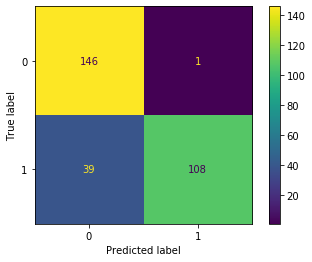

In [43]:
plot_confusion_matrix(svmc, X_valid, y_valid);

In [44]:
print("Training AUC: {:.1f}%.".format(roc_auc_score(y_train, y_hat_train_svm)*100))
print("Validation AUC: {:.1f}%.".format(roc_auc_score(y_valid, y_hat_valid_svm)*100))

Training AUC: 99.8%.
Validation AUC: 86.4%.


The SVM did not perform quite as well as the random forest. Once again, the model's recall lagged significantly behind the train set recall. However, the SVM proved to be the most precise of all of benchmark models. Notice that the model only predicted 1 false positive. Despite the precision, the SVM was unable to outperform our random forest model due to its recall score. 

From our benchmark models, the random forest is currently the one to beat with an AUC above 90% on the validation set. As we move onto our final models, it will be important to compare the best of those models with our random forest. If we cannot achieve materially higher performance with one of our neural network models, it may not be worth the additional complexity these models tend to introduce.

### Final Models

#### Fully Connected MLP Classifier

We'll begin by using a simple MLP (Multi-layer Perceptron) Classifier in sklearn. To arrive at the parameters below, we iterated on activation functions, depth of architecture, epochs, and different solvers optimizing for the log-loss function (cross entropy loss in our case).

In [84]:
#use greedy approach to parameter setting
#default loss is cross entropy

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(35, 15), max_iter=100, alpha=0.0001,
                    solver='adam', activation='relu', batch_size= 80, verbose=10, random_state=1,
                    n_iter_no_change=10, tol=0.0001)

mlp.fit(X_train, y_train)

Iteration 1, loss = 0.63346547
Iteration 2, loss = 0.51227318
Iteration 3, loss = 0.42012143
Iteration 4, loss = 0.34332321
Iteration 5, loss = 0.27896595
Iteration 6, loss = 0.22734190
Iteration 7, loss = 0.18297411
Iteration 8, loss = 0.14949125
Iteration 9, loss = 0.11999625
Iteration 10, loss = 0.09624713
Iteration 11, loss = 0.07923162
Iteration 12, loss = 0.06296531
Iteration 13, loss = 0.05118092
Iteration 14, loss = 0.04242296
Iteration 15, loss = 0.03490622
Iteration 16, loss = 0.02877796
Iteration 17, loss = 0.02319799
Iteration 18, loss = 0.01963639
Iteration 19, loss = 0.01674313
Iteration 20, loss = 0.01405891
Iteration 21, loss = 0.01211657
Iteration 22, loss = 0.01105427
Iteration 23, loss = 0.00918911
Iteration 24, loss = 0.00789604
Iteration 25, loss = 0.00692663
Iteration 26, loss = 0.00611812
Iteration 27, loss = 0.00549585
Iteration 28, loss = 0.00491872
Iteration 29, loss = 0.00443969
Iteration 30, loss = 0.00403563
Iteration 31, loss = 0.00367194
Iteration 32, los

MLPClassifier(batch_size=80, hidden_layer_sizes=(35, 15), max_iter=100,
              random_state=1, verbose=10)

Text(0.5, 1.0, 'Loss Curve')

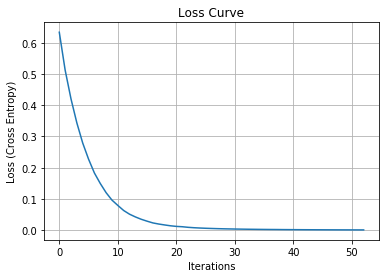

In [85]:
plt.plot(mlp.loss_curve_)
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Loss (Cross Entropy)')
plt.title('Loss Curve')

The loss curve allows us to see where performance tails off. After the 30th iteration or so, cross entropy loss begins to flat line. We continued for 23 iterations after that point because of the class imbalance in the data set. Every positive missclassification is more costly than the negative cases. Beyond the 53rd iteration, we saw no improvement in the validation AUC.

Our final parameters in our MLP classifier are as follows:

- Layer 1: 35
- Layer 2: 15
- 53 Iterations/Epochs
- 80 Batches
- Activation Function: Relu
- Solver: Adam

The parameters used in this classifier may provide a starting point in the next model that we build using TensorFlow, so we will keep them in mind. Let's look at our performance metrics.

In [86]:
print("Training set score: {:.4f}".format(mlp.score(X_train, y_train)))
print("Validation set score: {:.4f}".format(mlp.score(X_valid, y_valid)))

Training set score: 1.0000
Validation set score: 0.7925


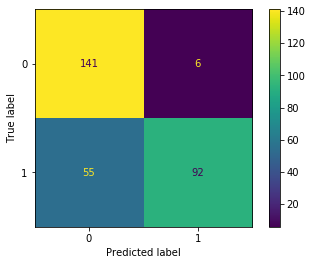

In [87]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(mlp, X_valid, y_valid);

In [88]:
y_hat_train_mlp = mlp.predict(X_train)
y_hat_valid_mlp = mlp.predict(X_valid)

In [89]:
precision_train_mlp = precision_score(y_train, y_hat_train_mlp, pos_label = 1) * 100
precision_valid_mlp = precision_score(y_valid, y_hat_valid_mlp, pos_label = 1) * 100
recall_train_mlp = recall_score(y_train, y_hat_train_mlp, pos_label = 1) * 100
recall_valid_mlp = recall_score(y_valid, y_hat_valid_mlp, pos_label = 1) * 100

print("Precision on training data: {:.1f}%".format(precision_train_mlp))
print("Recall on training data: {:.1f}% \n".format(recall_train_mlp))
print("Precision on validation data: {:.1f}%".format(precision_valid_mlp))
print("Recall on validation data: {:.1f}%".format(recall_valid_mlp))

Precision on training data: 100.0%
Recall on training data: 100.0% 

Precision on validation data: 93.9%
Recall on validation data: 62.6%


In [90]:
print("Training AUC: {:.1f}%.".format(roc_auc_score(y_train, y_hat_train_mlp)*100))
print("Validation AUC: {:.1f}%.".format(roc_auc_score(y_valid, y_hat_valid_mlp)*100))

Training AUC: 100.0%.
Validation AUC: 79.3%.


Our MLP classifier could not outperform the random forest or SVM classifier from our initial models. It also struggled to predict many of the positive cases (55 false negatives), repeating a theme from our SVM. Precision was high once again with only 6 false positives.

Using some of the knowledge we gained from iterating on the MLP classifier's parameters, let's see if we can build a more dense network in TensorFlow while including some regularization.

#### Tensorflow Dense Network with Dropout

Building a neural network in TensorFlow allows us greater control over the architecture of the model. In this section, we will build a neural network with a densely connected hidden layer and a dropout layer to reduce overfitting. The output will be a sigmoid layer which gives us the probability of an observation being defective, which we can classify as 1 or 0 using a 50% probability threshold (if probability of an observation > 50%, classify as 1). 

As a first step, TensorFlow will require us to convert our data frames into numpy arrays. Let's do that and then we can tune our hyperparameters.

In [52]:
#convert datasets to numpy arrays

X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

In [53]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

In [54]:
print('Train Set Shape:', X_train.shape)
print('Validation Set Shape:', X_valid.shape)
print('Test Set Shape:', X_test.shape)

print('Train Labels Shape:', y_train.shape)
print('Validation Labels Shape:', y_valid.shape)
print('Test Labels Shape:', y_test.shape)

Train Set Shape: (2338, 122)
Validation Set Shape: (294, 122)
Test Set Shape: (157, 122)
Train Labels Shape: (2338,)
Validation Labels Shape: (294,)
Test Labels Shape: (157,)


Our TensorFlow model parameters have been tuned according to performance on the validation set. The parameters tuned are defined below:
- epochs - # of full iterations over the samples
- batch_size -# of training examples in a single batch
- learning rate - Amount that weights are updated during training
- h_layer_seq - # of layers, size of layers, and sequence
- final_count - # of outputs (1 for binary classification)

The final model we built uses 3 layers (one hidden) with the sizes shown in the code block below, a learning rate of 0.001, 312 batch size, and 12 epochs. We tuned the model until we reached convergence between the training and validation sets and validation loss began to plateau.

In [70]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout

#-------------------------
# Set some hyper parameters
#-------------------------

# Total number of training epochs
epochs = 12

# Training batch size
batch_size = 312

# The optimization initial learning rate
learning_rate = 0.001

# Hidden layer sizes
h_layer_seq = [50, 15, 5]
final_count = 1

# x-data feature size
n_features = X_train.shape[1]

We added a 10% drop out rate that forces the model to work harder to find different paths in predicting the target. This prevents overfitting because each node in our model cannot rely on the output of other nodes. Setting the parameter to 10%, drops 10% of input elements, putting more pressure on other nodes to perform during the training process. We settled on this rate after 3 iterations on the validation set using 5%, 10%, and 20% dropout rates.

In [71]:
# Initialize a "sequential model" with tf.keras
model = tf.keras.Sequential()

# Add layers sequentially
for h_ix, h_num in enumerate(h_layer_seq):
    if h_ix == 0:
        # Need to set input Dimensions
        model.add(Dense(h_num, activation='relu', kernel_initializer='random_normal', input_shape=(n_features,)))
    else:
        model.add(Dense(h_num, activation='relu', kernel_initializer='random_normal'))
        # Add dropout!
        model.add(Dropout(rate=0.1))


# Add final output
model.add(Dense(final_count, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 50)                6150      
_________________________________________________________________
dense_13 (Dense)             (None, 15)                765       
_________________________________________________________________
dropout_6 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 80        
_________________________________________________________________
dropout_7 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 6         
Total params: 7,001
Trainable params: 7,001
Non-trainable params: 0
____________________________________________________

Next, we will set up an optimizer that implements the Adam algorithm. The Adam optimizer is a stochastic gradient descent method that looks to minimize, in our case, binary cross entropy loss. This is the standard loss function used for binary classification.

In [72]:
# Setup / Compile model
# Setup model with ADAM optimization & binary cross entropy loss

my_optmizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate, beta_1=0.8, beta_2=0.99, epsilon=1e-07, amsgrad=False,
    name='Adam')
model.compile(optimizer=my_optmizer, loss='binary_crossentropy', metrics=['AUC'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 50)                6150      
_________________________________________________________________
dense_13 (Dense)             (None, 15)                765       
_________________________________________________________________
dropout_6 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 80        
_________________________________________________________________
dropout_7 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 6         
Total params: 7,001
Trainable params: 7,001
Non-trainable params: 0
____________________________________________________

We are now ready to fit the model with the parameters specified above and evaluate our validation set AUC.

In [73]:
model_logs = model.fit(X_train, y_train,
                       epochs=epochs, batch_size=batch_size,
                       validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/12
8/8 [==============================] - 1s 75ms/step - loss: 0.6925 - auc: 0.5587 - val_loss: 0.6915 - val_auc: 0.6538
Epoch 2/12
8/8 [==============================] - 0s 5ms/step - loss: 0.6898 - auc: 0.7126 - val_loss: 0.6866 - val_auc: 0.8247
Epoch 3/12
8/8 [==============================] - 0s 4ms/step - loss: 0.6825 - auc: 0.8141 - val_loss: 0.6760 - val_auc: 0.8691
Epoch 4/12
8/8 [==============================] - 0s 5ms/step - loss: 0.6669 - auc: 0.8511 - val_loss: 0.6547 - val_auc: 0.8716
Epoch 5/12
8/8 [==============================] - 0s 4ms/step - loss: 0.6350 - auc: 0.8822 - val_loss: 0.6220 - val_auc: 0.8635
Epoch 6/12
8/8 [==============================] - 0s 5ms/step - loss: 0.5894 - auc: 0.8926 - val_loss: 0.5817 - val_auc: 0.8569
Epoch 7/12
8/8 [==============================] - 0s 4ms/step - loss: 0.5349 - auc: 0.9090 - val_loss: 0.5442 - val_auc: 0.8540
Epoch 8/12
8/8 [==============================] - 0s 5ms/step - loss: 0.4756 - auc: 0.9224 - val_loss: 

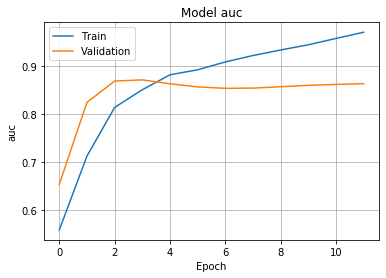

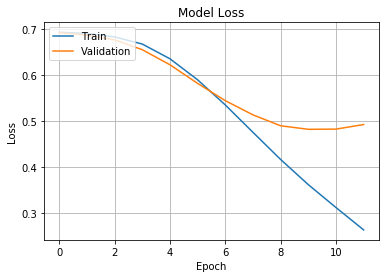

In [74]:
# Plot auc
plt.plot(model_logs.history['auc'])
plt.plot(model_logs.history['val_auc'])
plt.title('Model auc')
plt.ylabel('auc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()
plt.show()
# plot loss
plt.plot(model_logs.history['loss'])
plt.plot(model_logs.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()
plt.show()

We can see that the model converges around epoch 10. Note that the AUC we achieved with this model still underperforms our random forest benchmark model. Let's check our other performance metrics before making any decisions.

In [99]:
tf_train_prob = model.predict(X_train)
tf_valid_prob = model.predict(X_valid)

In [100]:
#set probabilities > 50% to 1

y_hat_train_tf = (tf_train_prob > 0.5)*1
y_hat_valid_tf = (tf_valid_prob > 0.5)*1

In [101]:
model.evaluate(X_valid, y_valid, verbose = 1)

10/10 [==============================] - 0s 1ms/step - loss: 0.4925 - auc: 0.8638


[0.49247512221336365, 0.8637604713439941]

In [102]:
#generate confusion matrix

from sklearn.metrics import confusion_matrix

train_cmatrix = confusion_matrix(y_train, y_hat_train_tf)
valid_cmatrix = confusion_matrix(y_valid, y_hat_valid_tf)

In [103]:
#create & print precision-recall variables

tf_precision_train = train_cmatrix[1][1]/(train_cmatrix[1][1] + train_cmatrix[0][1])*100
tf_recall_train = train_cmatrix[1][1]/(train_cmatrix[1][1] + train_cmatrix[1][0])*100
tf_precision_valid = valid_cmatrix[1][1]/(valid_cmatrix[1][1] + valid_cmatrix[0][1])*100
tf_recall_valid = valid_cmatrix[1][1]/(valid_cmatrix[1][1] + valid_cmatrix[1][0])*100
print("Train set precision: {:.1f}%".format(tf_precision_train))
print("Train set recall: {:.1f}% \n".format(tf_recall_train))
print("Validation set precision: {:.1f}%".format(tf_precision_valid))
print("Validation set recall: {:.1f}%".format(tf_recall_valid))

Train set precision: 94.0%
Train set recall: 95.8% 

Validation set precision: 84.7%
Validation set recall: 71.4%


Despite building a deeper architecture and adding dropout to our neural network, we were not able to outperform the random forest classifier, which had an AUC above 90%.

In our final section, we will predict on the test set using our random forest and TensorFlow model. While we can assess the performance of these models on the test set, it is common practice to finish tuning parameters during the training and validation phase so that the test set is not biased in any way. The final section will therefore only be used to choose a final model. This is our best simulation of how the model might perform on an unseen data set.

### Choosing a Final Model

We'll start by checking the random forest's performance metrics.

In [104]:
#predict and check accuracy

y_hat_test_rf = clf_rf.predict(X_test)
acc_test_rf = accuracy_score(y_test, y_hat_test_rf)

print('Test set rf accuracy: {:.2f}%'.format(acc_test_rf * 100))

Test set rf accuracy: 91.08%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


In [105]:
recall_test_rf = recall_score(y_test, y_hat_test_rf, pos_label = 1) * 100
precision_test_rf = precision_score(y_test, y_hat_test_rf, pos_label = 1) * 100

print("Precision on test data: {:.1f}%".format(precision_test_rf))
print("Recall on test data: {:.1f}%".format(recall_test_rf))

Precision on test data: 16.7%
Recall on test data: 10.0%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


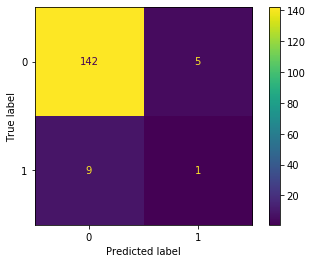

In [106]:
plot_confusion_matrix(clf_rf, X_test, y_test);

In [107]:
print("Validation AUC: {:.1f}%.".format(roc_auc_score(y_test, y_hat_test_rf)*100))

Validation AUC: 53.3%.


The random forest model performed significantly worse on the test set. With an AUC of only 53%, the model performs hardly better than a coin flip. Both precision and recall were near zero. As expected, the model was not able to detect defective products due to the class imbalance and small sample. Random forest is typically an algorithm which requires a lot of data because it uses a high volume of decision trees in its training process.

Let's see if our TensorFlow model can outperform this model.

In [108]:
tf_test_prob = model.predict(X_test)
y_hat_test_tf = (tf_test_prob > 0.5)*1

In [109]:
model.evaluate(X_test, y_test, verbose = 1)

5/5 [==============================] - 0s 2ms/step - loss: 0.3417 - auc: 0.7238


[0.3416617214679718, 0.723809540271759]

In [110]:
test_cmatrix = confusion_matrix(y_test, y_hat_test_tf)
tf_precision_test = test_cmatrix[1][1]/(test_cmatrix[1][1] + test_cmatrix[0][1])*100
tf_recall_test = test_cmatrix[1][1]/(test_cmatrix[1][1] + test_cmatrix[1][0])*100

print("Test set precision: {:.1f}%".format(tf_precision_test))
print("Test set recall: {:.1f}%".format(tf_recall_test))

Test set precision: 12.5%
Test set recall: 20.0%


With an AUC of 72%, the TF model significantly outperforms our random forest classifier despite not performing quite as well on the validation set. It's ability to perform better on an imbalanced set of data, which is what the model will face in reality, should provide us more confidence that it will better than the random forest in a production environment.

## Findings

Our goal in building these data models and analysis was to see whether we could build a machine learning model that would predict whether a particular product in the diaper manufacturing process is defective ahead of time, using sensor information collected on each observation. Of the models built in this process, our final model, which was built using TensorFlow proved to be the most robust with an AUC of 72% on the test set. Having said that, the final model chosen here should be used in production with caution. The precision and recall of this model was under 25%, meaning it was unable to detect most of the positive cases and predicted many false positives.

With 1567 observations and only ~7% of them, as defective; our models were not able to produce very consistent results on unseen data. To optimize these models, we suggest collecting more data (including non sensor data as well) to be used in training. This will help the models built here to learn the underlying structures and relationships within the data better. As expected, each of the models predicted the majority class very well, but could not identify positive cases well.

If false positives/negatives are expected to be very costly to the organization and there are other investment risks associated with building processes around an inconsistent model such as this, it may be more valuable to build a rule based classifier using the most predictive sensors from our analysis and other related domain knowledge. Doing this could be both interpretable for decision makers and also moderately accurate in production, all without having to spend the resources required to deploy a fully connected neural network.